In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def load_image(image_path, size=512):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image

def imshow(tensor, title=None):
    # Отсоединяем тензор от графа вычислений и перемещаем его на CPU
    image = tensor.detach().cpu().clone().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Де-нормализация
    image = image.clip(0, 1)  # Ограничение значений в диапазоне [0, 1]

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Для обновления изображения



In [3]:
style_img = load_image("./data/images/picasso.jpg")
content_img = load_image("./data/images/macarons.jpg")

assert style_img.size() == content_img.size(), "Images must be the same size."


In [4]:
style_img = load_image("./data/images/picasso.jpg")
content_img = load_image("./data/images/macarons.jpg")

assert style_img.size() == content_img.size(), "Images must be the same size."


In [5]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

# загрузим VGG-16 model
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval().to(device)

# нормализуем параметры
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [7]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img):
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name == 'conv_4':
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


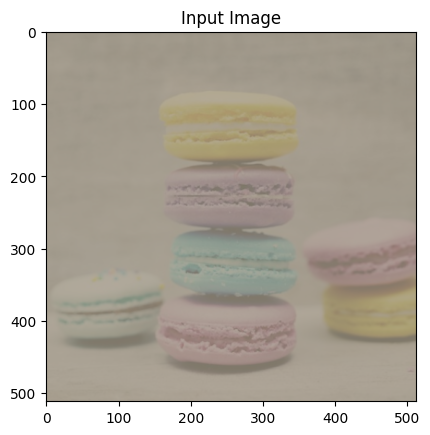

In [8]:
# To use the original content image as the initial input image
input_img = content_img.clone()

# Uncomment to use noise as the starting point
# input_img = torch.randn(content_img.data.size()).to(device)

# Display the initial input image
plt.figure()
imshow(input_img, title='Input Image')


In [9]:

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):

    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing the image...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}')
                print()

            return style_score + content_score

        optimizer.step(closure)


    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


Building the style transfer model...
Optimizing the image...
run 50:
Style Loss : 1.044356 Content Loss: 0.379866

run 100:
Style Loss : 0.998064 Content Loss: 0.391625

run 150:
Style Loss : 0.967523 Content Loss: 0.399707

run 200:
Style Loss : 0.946451 Content Loss: 0.404715

run 250:
Style Loss : 0.927229 Content Loss: 0.409174

run 300:
Style Loss : 0.907615 Content Loss: 0.415760



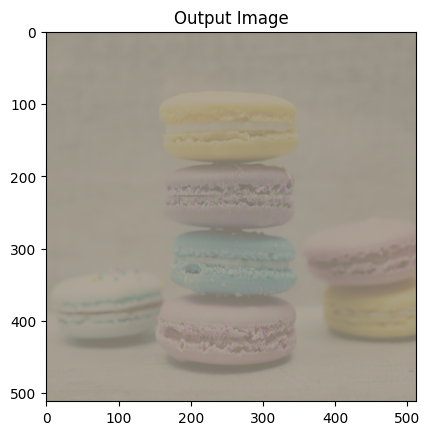

In [10]:
# Execute the style transfer
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Display the output image
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
